## Import libraries

In [1]:
import pandas as pd
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from IPython.display import display_html
from scipy.optimize import least_squares

## Load data

In [2]:
ROOT = Path.cwd().parent

data_path = ROOT / 'data'

In [3]:
data_long = pd.read_csv(data_path / 'Regions_to_USA.csv')
df = data_long.pivot(index='month', columns='region', values='export_value').reset_index()
df['month'] = pd.to_datetime(df['month'])

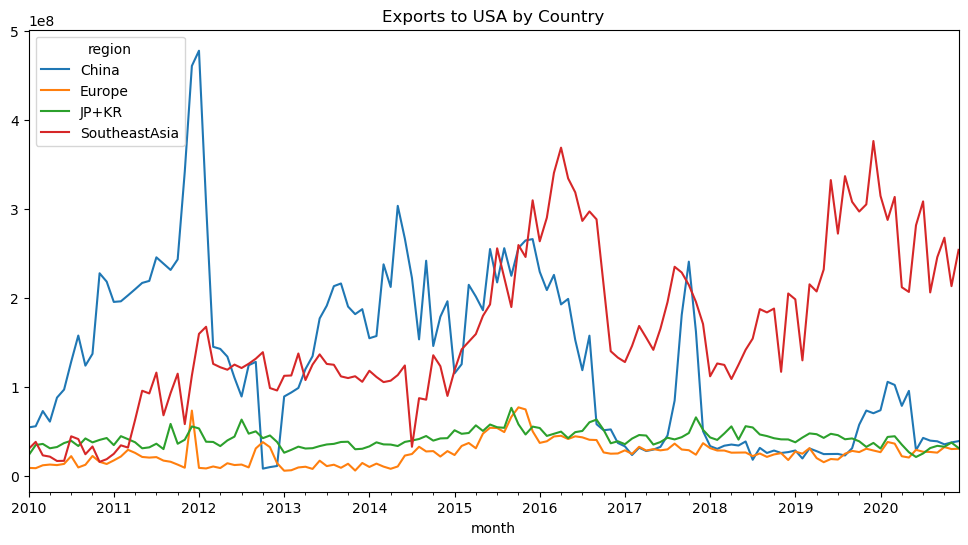

In [4]:
df.set_index('month').plot(figsize=(12, 6), title='Exports to USA by Country')
plt.show()

## Model

In [6]:
# Fill missing values (optional)
df = df.fillna(method='ffill').fillna(method='bfill')

df

/var/folders/rx/w1hnwhnx0yd75fmrmyfvf0680000gn/T/ipykernel_7590/4130673222.py:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill').fillna(method='bfill')


region,month,China,Europe,JP+KR,SoutheastAsia
0,2010-01-01,5.485927e+07,9.460980e+06,2.358622e+07,3.064121e+07
1,2010-02-01,5.619061e+07,9.135599e+06,3.511262e+07,3.866245e+07
2,2010-03-01,7.322346e+07,1.240549e+07,3.635841e+07,2.351316e+07
3,2010-04-01,6.137866e+07,1.320538e+07,3.146956e+07,2.207556e+07
4,2010-05-01,8.829792e+07,1.258765e+07,3.286948e+07,1.723182e+07
...,...,...,...,...,...
127,2020-08-01,4.004647e+07,2.732592e+07,3.171709e+07,2.063062e+08
128,2020-09-01,3.928391e+07,2.656817e+07,3.420311e+07,2.458481e+08
129,2020-10-01,3.588563e+07,3.282852e+07,3.322190e+07,2.676746e+08
130,2020-11-01,3.804170e+07,3.060402e+07,3.783671e+07,2.133280e+08


In [8]:
data_long['region'].unique()

array(['China', 'Europe', 'JP+KR', 'SoutheastAsia'], dtype=object)

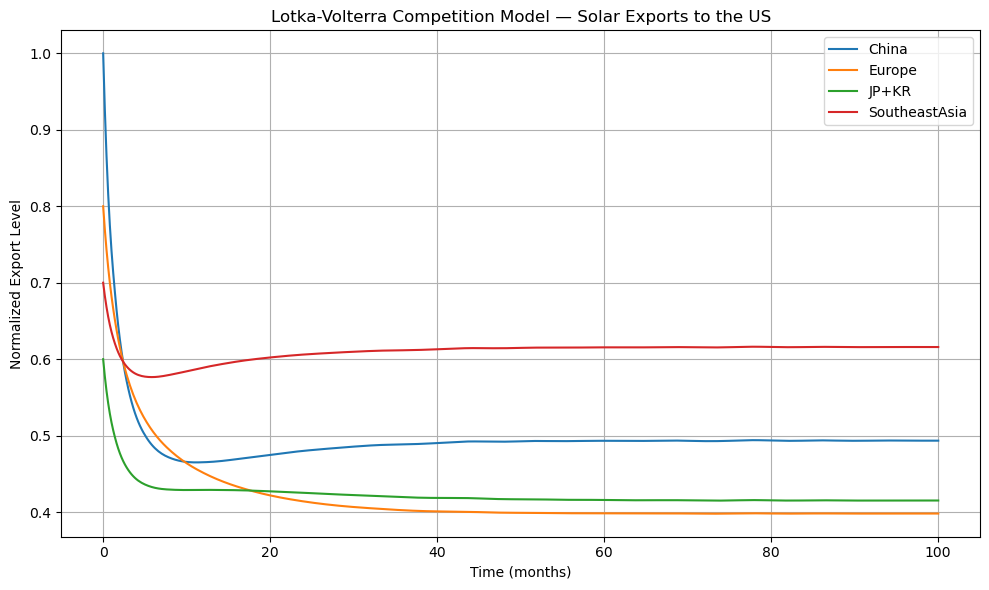

In [10]:
def lotka_volterra_explicit(t, X, r1, r2, r3, r4,
                             a11, a12, a13, a14,
                             a21, a22, a23, a24,
                             a31, a32, a33, a34,
                             a41, a42, a43, a44):
    x1, x2, x3, x4 = X

    dx1dt = r1 * x1 * (1 - a11 * x1 - a12 * x2 - a13 * x3 - a14 * x4)
    dx2dt = r2 * x2 * (1 - a21 * x1 - a22 * x2 - a23 * x3 - a24 * x4)
    dx3dt = r3 * x3 * (1 - a31 * x1 - a32 * x2 - a33 * x3 - a34 * x4)
    dx4dt = r4 * x4 * (1 - a41 * x1 - a42 * x2 - a43 * x3 - a44 * x4)

    return [dx1dt, dx2dt, dx3dt, dx4dt]

# Parameters (example values, adjust as needed)
params = {
    'r1': 0.5, 'r2': 0.3, 'r3': 0.4, 'r4': 0.35,
    'a11': 1.0, 'a12': 0.6, 'a13': 0.2, 'a14': 0.3,
    'a21': 0.3, 'a22': 1.0, 'a23': 0.5, 'a24': 0.4,
    'a31': 0.4, 'a32': 0.2, 'a33': 1.0, 'a34': 0.5,
    'a41': 0.2, 'a42': 0.3, 'a43': 0.4, 'a44': 1.0
}

# Initial conditions (example, adjust as needed)
X0 = [1.0, 0.8, 0.6, 0.7]

# Time span and evaluation points
t_span = (0, 100)
t_eval = np.linspace(*t_span, 500)

# Solve the system
sol = solve_ivp(
    fun=lambda t, X: lotka_volterra_explicit(t, X, **params),
    t_span=t_span,
    y0=X0,
    t_eval=t_eval,
    method='RK45'
)

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(sol.t, sol.y[0], label='China')
plt.plot(sol.t, sol.y[1], label='Europe')
plt.plot(sol.t, sol.y[2], label='JP+KR')
plt.plot(sol.t, sol.y[3], label='SoutheastAsia')
plt.title('Lotka-Volterra Competition Model — Solar Exports to the US')
plt.xlabel('Time (months)')
plt.ylabel('Normalized Export Level')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Model Calibration

In [11]:
china_data = df['China']
europe_data = df['Europe']
jpkr_data = df['JP+KR']
southeastasia_data = df['SoutheastAsia']

# Stack data for comparison
data = np.vstack([china_data, europe_data, jpkr_data, southeastasia_data])  # shape (4, T)
t_data = np.linspace(0, len(china_data)-1, len(china_data))  # e.g. months

In [12]:
def residuals(params, X0, t_data, data):
    r1, r2, r3, r4 = params[:4]
    a11, a12, a13, a14 = params[4:8]
    a21, a22, a23, a24 = params[8:12]
    a31, a32, a33, a34 = params[12:16]
    a41, a42, a43, a44 = params[16:20]

    sol = solve_ivp(
        fun=lambda t, X: lotka_volterra_explicit(
            t, X, r1, r2, r3, r4,
            a11, a12, a13, a14,
            a21, a22, a23, a24,
            a31, a32, a33, a34,
            a41, a42, a43, a44
        ),
        t_span=(t_data[0], t_data[-1]),
        y0=X0,
        t_eval=t_data,
        method='RK45'
    )

    if sol.y.shape[1] != len(t_data):
        return np.ones(data.size) * 1e6

    return (sol.y - data).ravel()

In [13]:
# Initial guess for 4 regions: r1, r2, r3, r4, a11, a12, a13, a14, ..., a44 (total 20 params)
initial_guess = [
    0.5, 0.3, 0.4, 0.35,   # r1, r2, r3, r4
    1.0, 0.6, 0.2, 0.3,    # a11, a12, a13, a14
    0.3, 1.0, 0.5, 0.4,    # a21, a22, a23, a24
    0.4, 0.2, 1.0, 0.5,    # a31, a32, a33, a34
    0.2, 0.3, 0.4, 1.0     # a41, a42, a43, a44
]

# Initial export levels from your data
X0 = data[:, 0]

# Fit the model
result = least_squares(residuals, initial_guess, args=(X0, t_data, data),
                       bounds=(0, 10))  # constrain params to be positive

# Extract best-fit parameters
fitted_params = result.x

In [14]:
fitted_params

array([0.34850641, 5.26449283, 0.32338699, 0.98482024, 0.64361537,
       0.31662944, 0.10515398, 0.1452122 , 2.93396846, 3.93267881,
       3.54583091, 3.54831534, 0.36279456, 0.18243403, 0.92233563,
       0.49687961, 0.1035298 , 0.15526119, 0.20191567, 0.49891561])

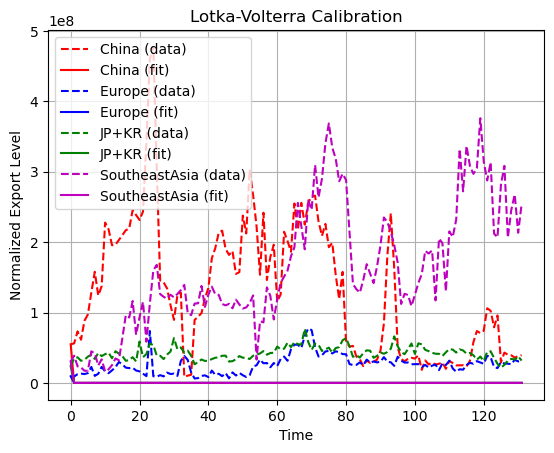

In [15]:
sol = solve_ivp(
    fun=lambda t, X: lotka_volterra_explicit(t, X, *fitted_params),
    t_span=(t_data[0], t_data[-1]),
    y0=X0,
    t_eval=t_data
)

# Plot
plt.plot(t_data, data[0], 'r--', label='China (data)')
plt.plot(t_data, sol.y[0], 'r-', label='China (fit)')
plt.plot(t_data, data[1], 'b--', label='Europe (data)')
plt.plot(t_data, sol.y[1], 'b-', label='Europe (fit)')
plt.plot(t_data, data[2], 'g--', label='JP+KR (data)')
plt.plot(t_data, sol.y[2], 'g-', label='JP+KR (fit)')
plt.plot(t_data, data[3], 'm--', label='SoutheastAsia (data)')
plt.plot(t_data, sol.y[3], 'm-', label='SoutheastAsia (fit)')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Normalized Export Level')
plt.title('Lotka-Volterra Calibration')
plt.grid(True)
plt.show()